# Comparison of results and choice of hyper_params. 

In [270]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.data_class import Data
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
from dmd_functions import *
from tensorflow import keras
import pickle
import numpy as np
from numpy import matlib

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

# Step 1: Read in a random test batch. 

In [272]:
random_batch = pickle.load(open('./data/ex2_random_batch.pkl', 'rb'))
random_batch = random_batch.numpy()

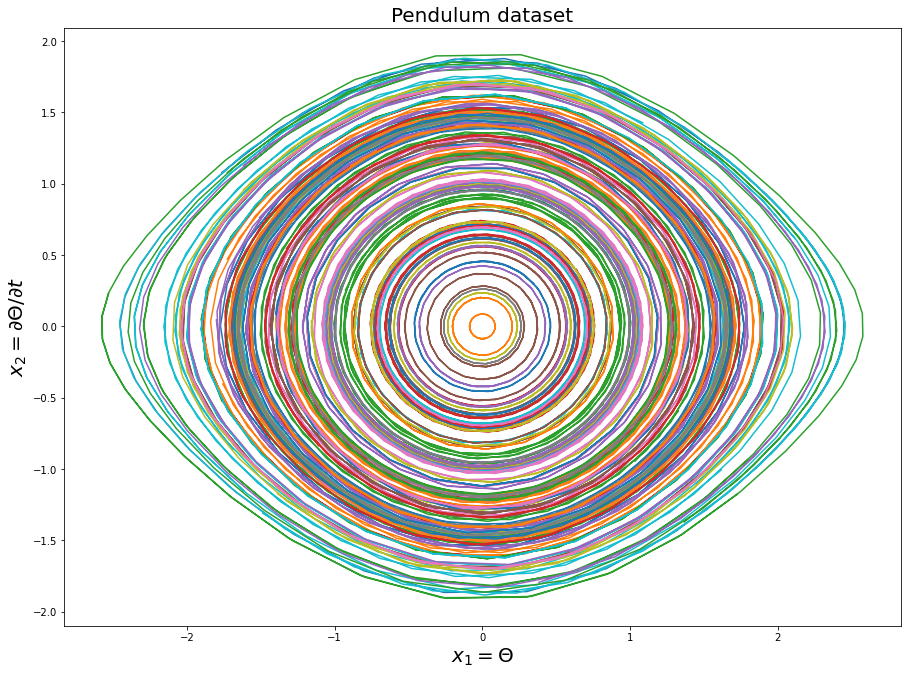

In [273]:
_ = plt.figure(figsize=(15,11))
for ii in np.arange(0, 256, 2):
    plt.plot(random_batch[ii, 0, :], random_batch[ii, 1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)
plt.show()


# Step 2: Analyze DMD. 

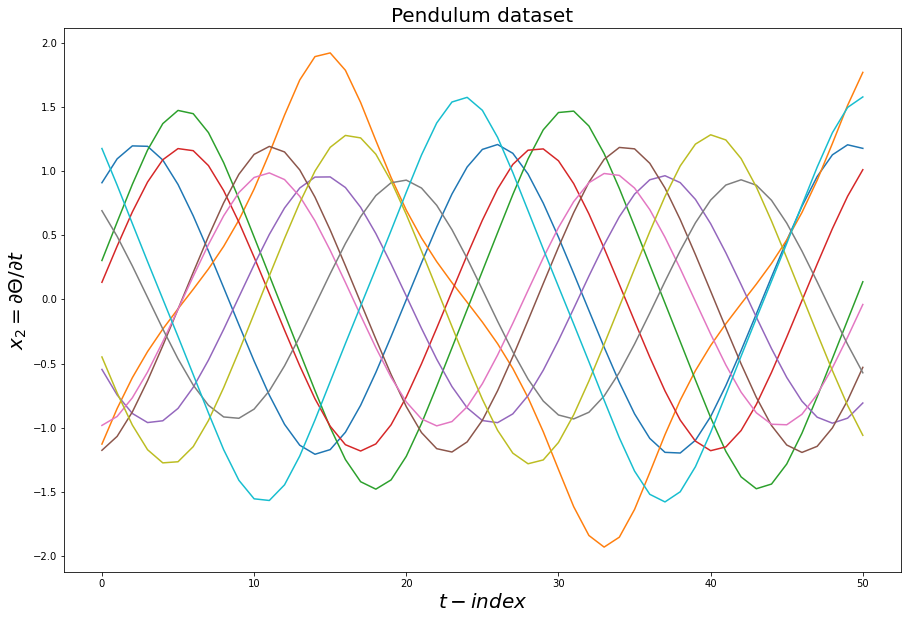

In [274]:
_ = plt.figure(figsize=(15, 10))
for ii in range(0, 10):
    plt.plot(np.arange(len(random_batch[ii, 1, :])), random_batch[ii, 1, :])


plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.xlabel("$ t -index$", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)

plt.show()

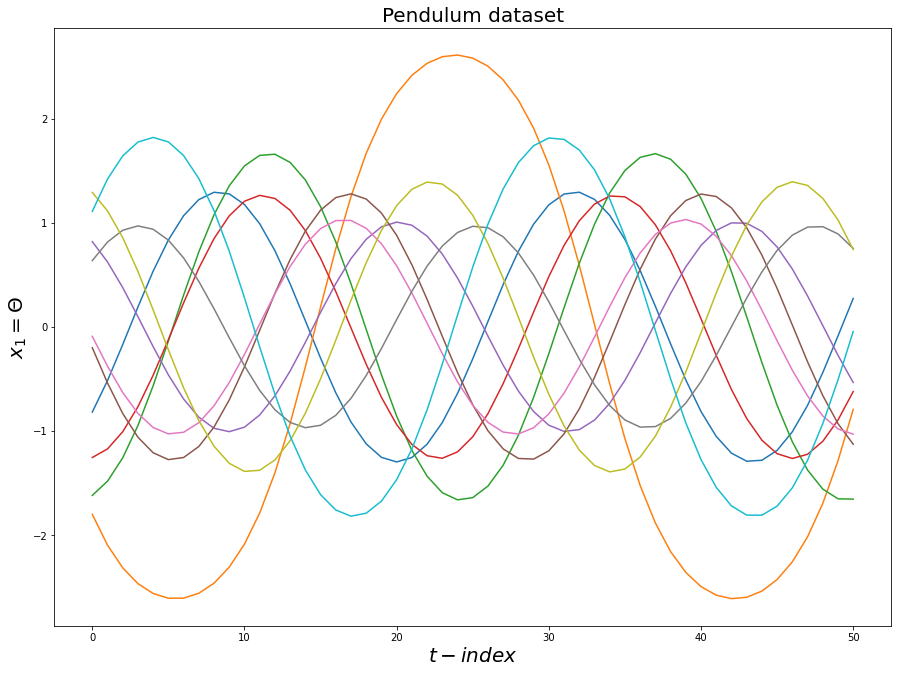

In [275]:
_ = plt.figure(figsize=(15, 11))
for ii in range(0, 10):
    plt.plot(np.arange(len(random_batch[ii, 0, :])), random_batch[ii, 0, :])


plt.ylabel("$x_{1}= \Theta $", fontsize=20)
plt.xlabel("$ t -index$", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)

plt.show()

In [276]:
def dmd_fit(x_mat):
    # Perform DMD method
    x_minus = x_mat[:, :-1]
    x_plus = x_mat[:, 1:]

    # singular value decomposition.
    u, s, vh = np.linalg.svd(x_minus, full_matrices=False)
    u, vh = np.matrix(u), np.matrix(vh)

    # compute Atilde.
    Atilde = x_plus @ vh.H
    Atilde = Atilde @ np.diag(1. / s)
    Atilde = Atilde @ u.H

    # compute the eigenvalues and eigenvectors of Atilde.
    eigs, eig_vecs = np.linalg.eig(Atilde)

    # find b.
    b = np.linalg.solve(eig_vecs, x_mat[:, 0])

    # reconstruct dmd.
    dmd_rec = np.zeros((x_mat.shape[0], x_mat.shape[1]))
    
    dmd_rec[:, 0] = x_mat[:, 0]
    for ii in range(1, x_mat.shape[1]):
        # dmd_rec[:, ii] = eig_vecs @ np.diag(np.exp(np.log(eigs)*ii)) @ b
        dmd_rec[:, ii] = (Atilde**ii) @ x_mat[:, 0]
    return [eigs, eig_vecs, b, dmd_rec.real]

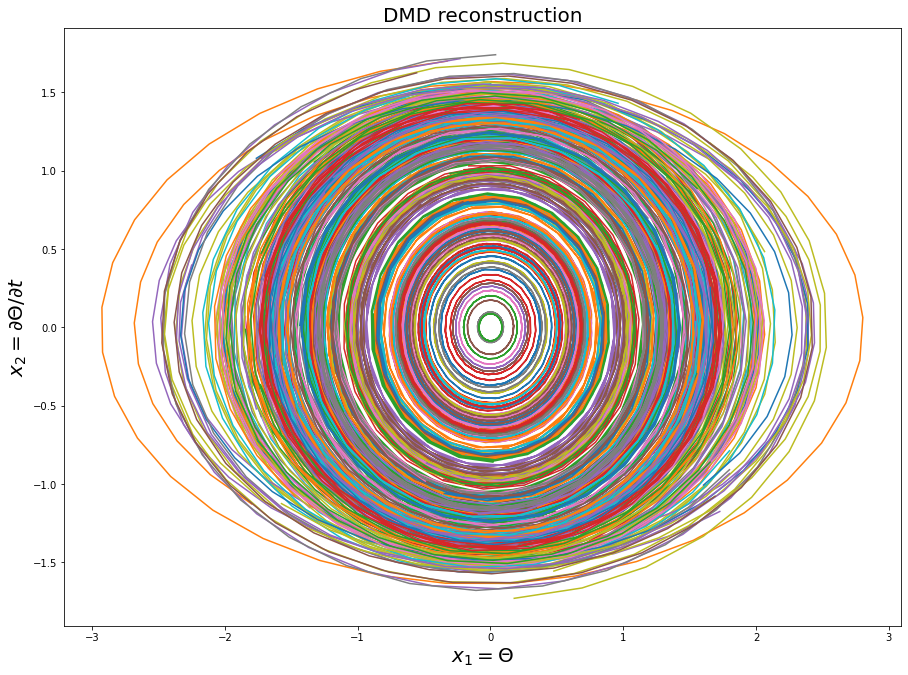

In [277]:
_ = plt.figure(figsize=(15,11))
dmd_rec_mat = np.zeros((random_batch.shape[0], random_batch.shape[1], random_batch.shape[2]))
for ii in np.arange(0, 256):
    eigs, eig_vecs, b, dmd_rec = dmd_fit(random_batch[ii])
    dmd_rec_mat[ii] = dmd_rec
    plt.plot(dmd_rec[0, :], dmd_rec[1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("DMD reconstruction", fontsize=20)
plt.show()

In [278]:
((dmd_rec_mat - random_batch)**2).mean()

0.003354696547587

# Step 3: Load a saved model. 

In [279]:
hyp_params = dict()
hyp_params['num_t_steps'] = 51
hyp_params['num_phys_dims'] = 2
hyp_params['num_init_conds'] = 1000
hyp_params['batch_size'] = 256 # MAJOR PARAMETER CHOICE
hyp_params['num_epochs'] = 500  # MAJOR PARAMETER CHOICE

# Encoding/Decoding Layer Parameters
hyp_params['num_en_layers'] = 2 # MAJOR PARAMETER CHOICE
hyp_params['num_en_neurons'] = 80  # MAJOR PARAMETER CHOICE
hyp_params['latent_dim'] = 2

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['regfac'] = 3e-3

hyp_params['c1'] = 1 # coefficient autoencoder loss.
hyp_params['c2'] = 1 # coefficient of dmd loss. 
hyp_params['c3'] = 1 # coefficient of pred loss. 


myMachine = DMDMachine(hyp_params)

print("DMD Loss on input dataset = ", (myMachine.get_linearity_loss(tf.convert_to_tensor(random_batch)).numpy()))

y_pred = DMDMachine.compute_pred_batch_mat(myMachine, y_data_mat=tf.convert_to_tensor(random_batch))

print("Pred Loss on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(random_batch), y_pred)).numpy())

plot_dmd_eigs(Amat, 0, None, "input")

DMD Loss on input dataset =  0.043632064
Pred Loss on input dataset =  0.003354696567412712


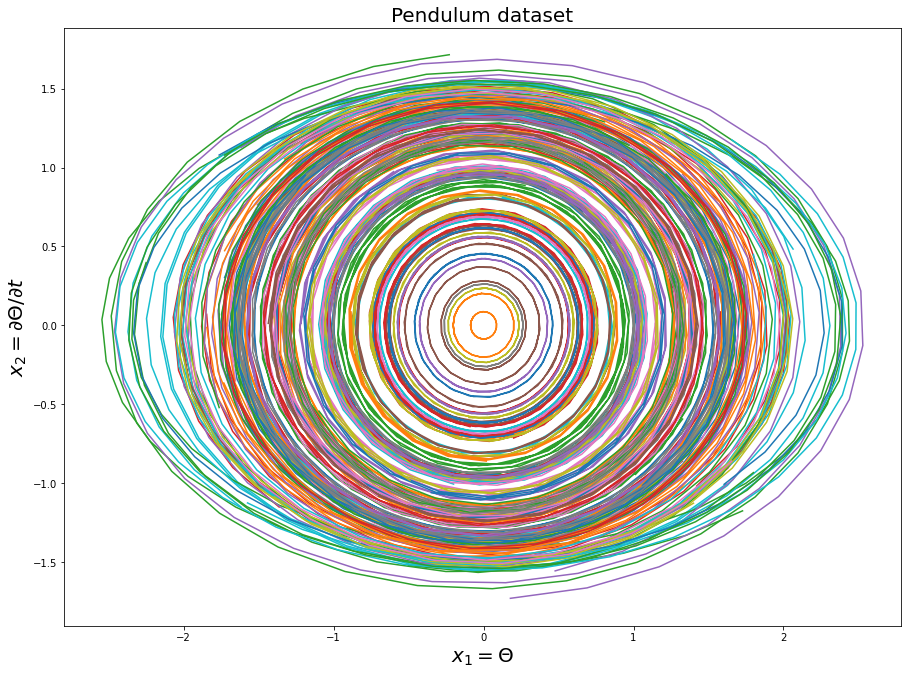

In [280]:
y_pred = y_pred.numpy()
_ = plt.figure(figsize=(15,11))
for ii in np.arange(0, 256, 2):
    plt.plot(y_pred[ii, 0, :], y_pred[ii, 1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)
plt.show()


In [281]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct2", compile=False)

In [282]:
test_run = myMachine(random_batch)

## Step 3: plot results.

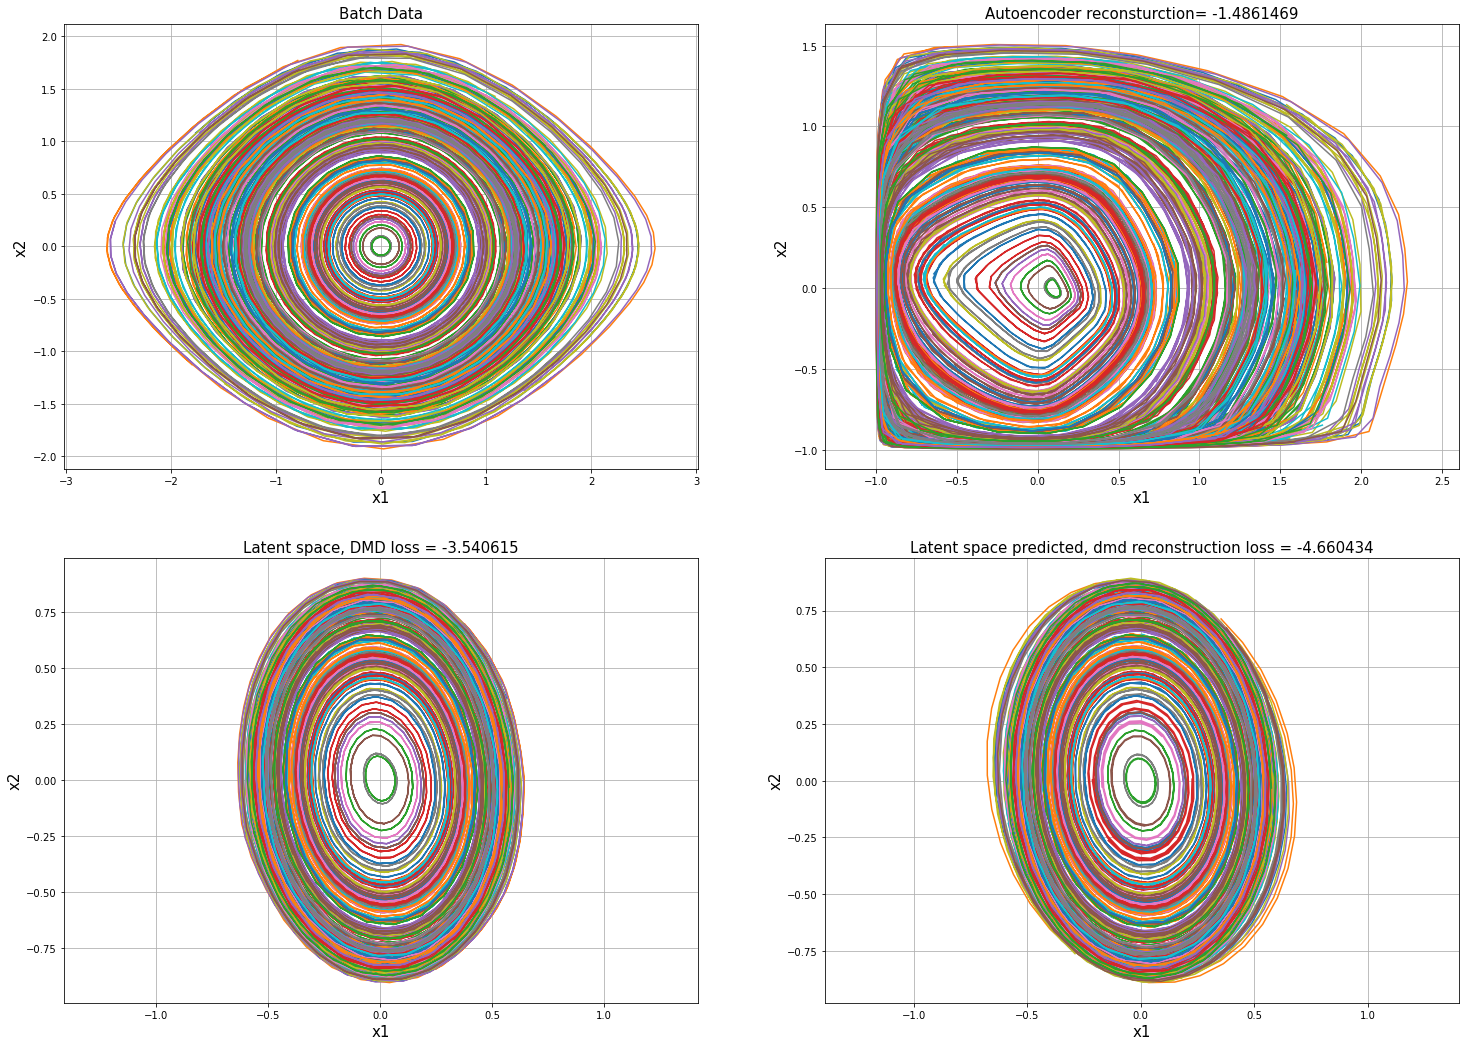

In [283]:
new_plot_model(test_run, random_batch)

# Step 4: Repeat for all models saved. 

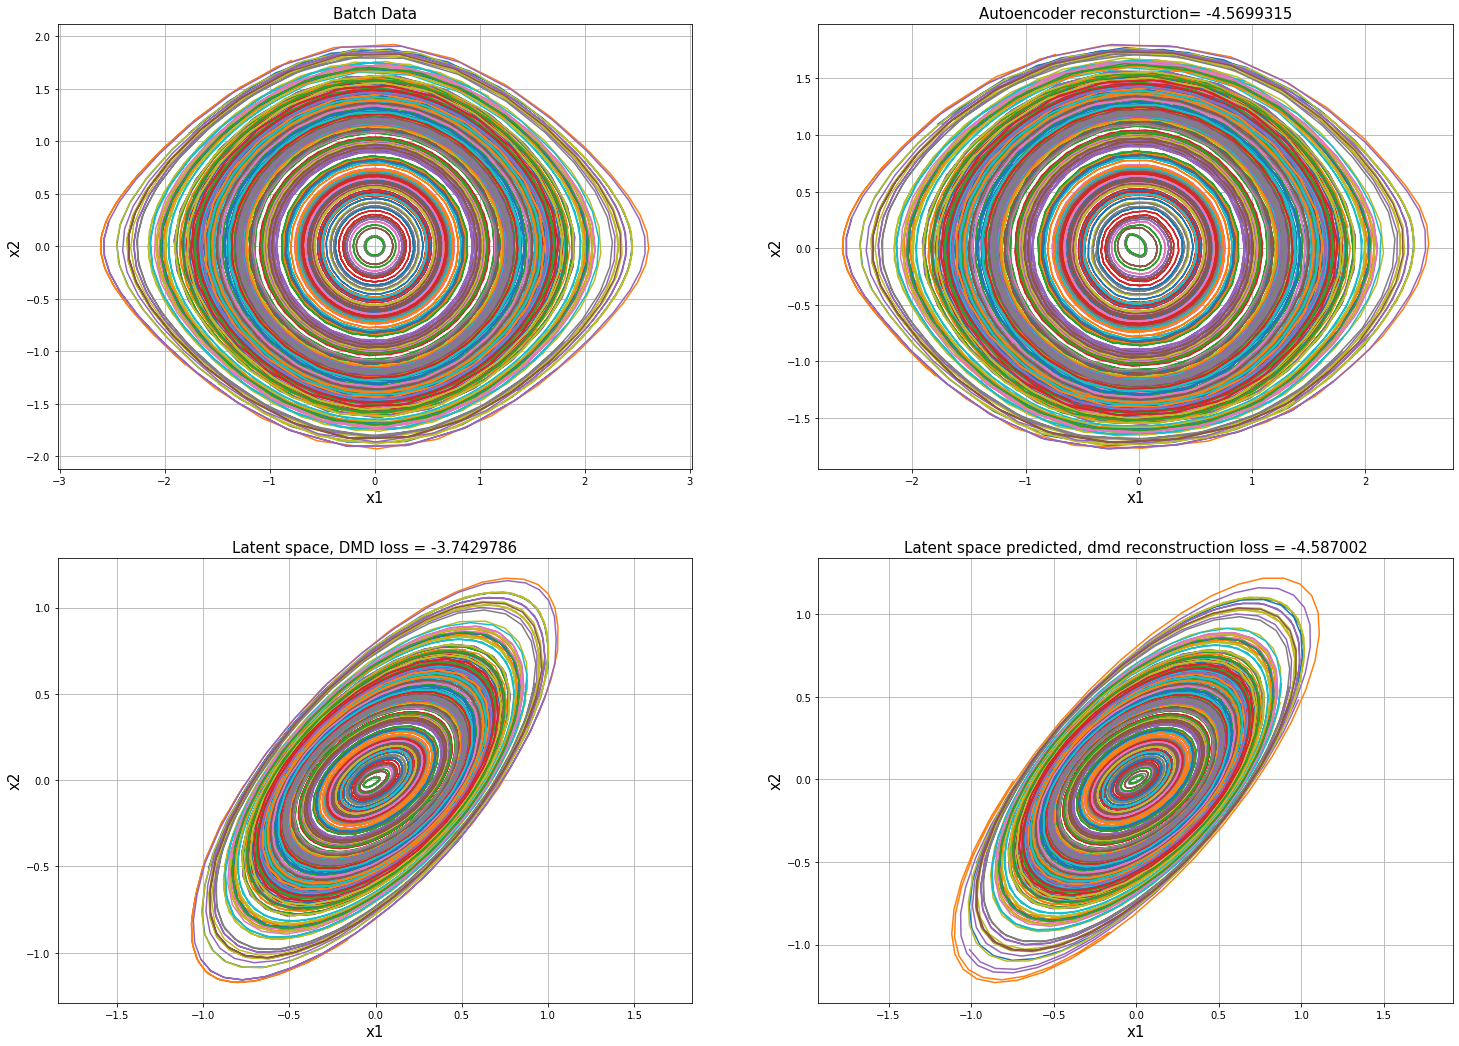

In [284]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct21", compile=False)
test_run = myMachine(random_batch)
new_plot_model(test_run, random_batch)

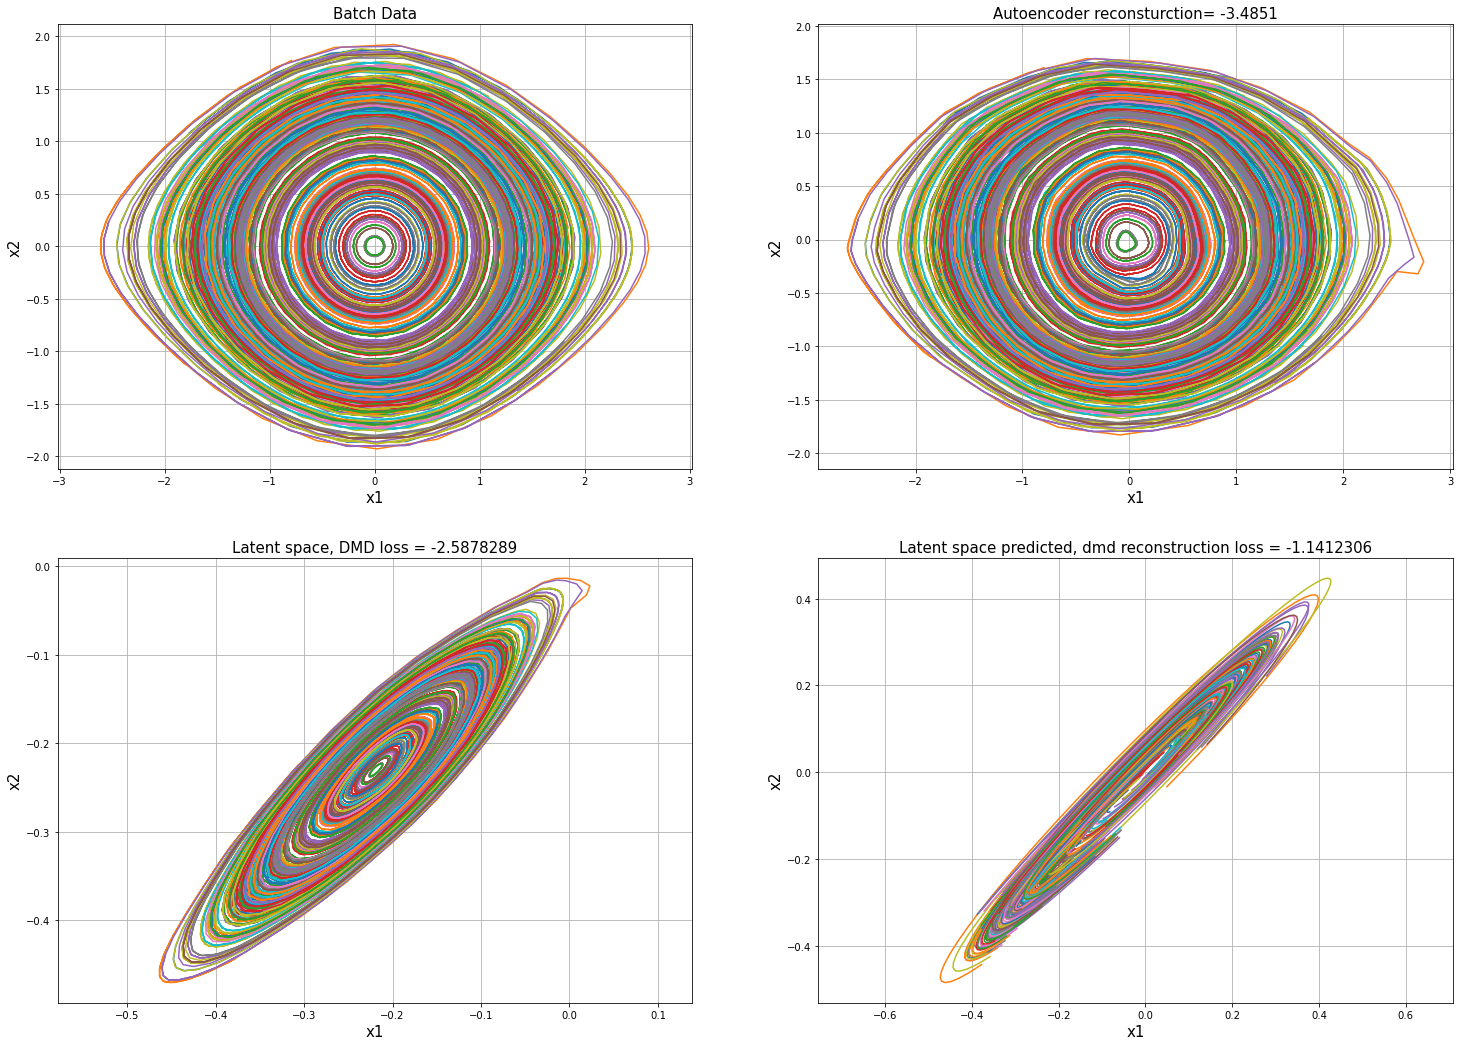

In [285]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct19", compile=False)
test_run = myMachine(random_batch)
new_plot_model(test_run, random_batch)